# Hệ thống gợi ý MovieLens
Notebook này đi xuyên suốt toàn bộ yêu cầu: thu thập dữ liệu, làm sạch, trực quan hóa, xây dựng mô hình, đánh giá và phân tích định tính.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
import pandas as pd
from src import data_ingestion, data_cleaning
from src.features import FeatureStore, build_user_item_matrix
from src.visualization import (plot_rating_distribution, plot_top_genres, plot_top_movies_by_ratings, plot_rating_heatmap)
from src.recommender import ContentBasedRecommender, MatrixFactorizationRecommender, HybridRecommender
from src.evaluation import rmse, mae, precision_at_k, recall_at_k

## 1. Thu thập dữ liệu
Script `scripts/download_movielens.py` hỗ trợ tải và giải nén MovieLens latest-small (≈9.7K phim, 100K lượt chấm). Chỉ cần chạy một lần cho mỗi môi trường.

In [2]:
# !python scripts/download_movielens.py --output data/raw

## 2. Nạp & làm sạch
Đọc các file CSV thô, hợp nhất, xử lý thiếu, bỏ trùng và tổng hợp thống kê cho từng phim.

In [3]:
raw_dir = PROJECT_ROOT / 'data/raw'
raw_data = data_ingestion.load_raw_data(raw_dir)
master_df = data_cleaning.build_master_frame(raw_data)
master_df.head()

,userId,movieId,rating,timestamp,title,genres,tag_text,year,avg_rating,rating_count,rating_std,genre_list,clean_title
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun pixar,1995.0,3.920930,114.54,0.834859,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,moldy old,1995.0,3.259615,52.00,1.054823,"[Comedy, Romance]",Grumpier Old Men
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,,1995.0,3.946078,102.00,0.817224,"[Action, Crime, Thriller]",Heat
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,mystery serial killer twist ending,1995.0,3.975369,114.54,0.922429,"[Mystery, Thriller]",Seven (a.k.a. Se7en)
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,heist mindfuck suspense thriller tricky twist ...,1995.0,4.237745,114.54,0.800921,"[Crime, Mystery, Thriller]","Usual Suspects, The"


### Danh sách làm sạch
- Điền giá trị thiếu theo kiểu dữ liệu từng cột
- Loại bỏ dòng trùng `(userId, movieId, timestamp)`
- Winsorize số lượt đánh giá để hạn chế outlier
- Ghép tag đã chuẩn hóa làm text blob phục vụ TF-IDF

## 3. Khám phá dữ liệu (EDA)
Sinh các biểu đồ yêu cầu: phân bố rating, tần suất thể loại, top phim và heatmap user–item.

D:\KHDL_cuoiky\src\visualization.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


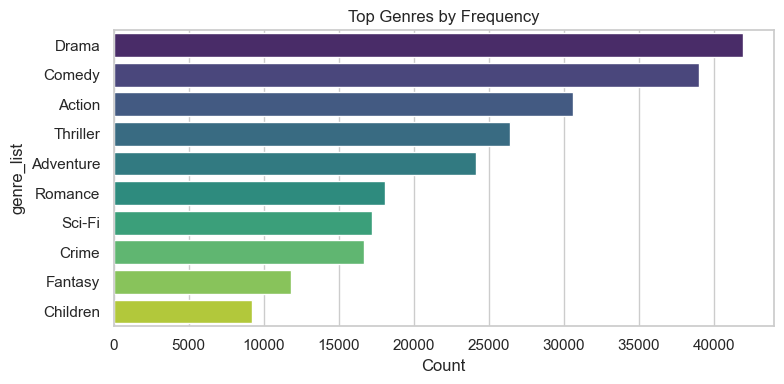

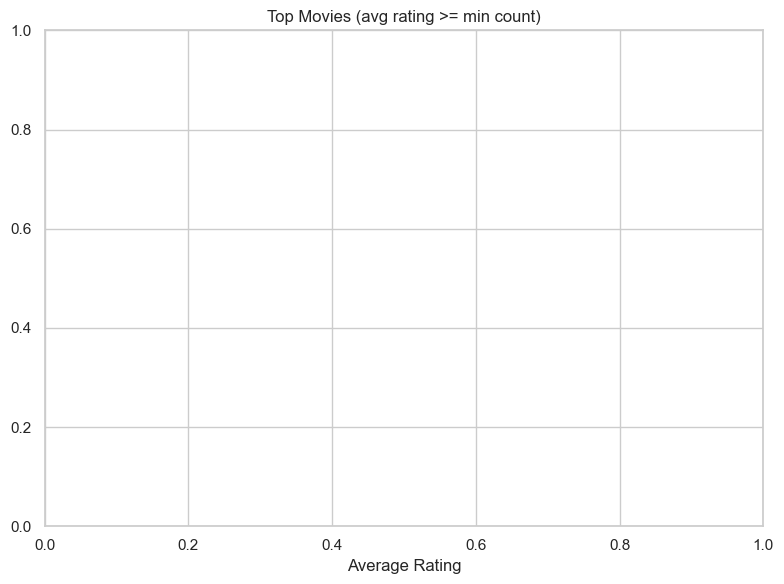

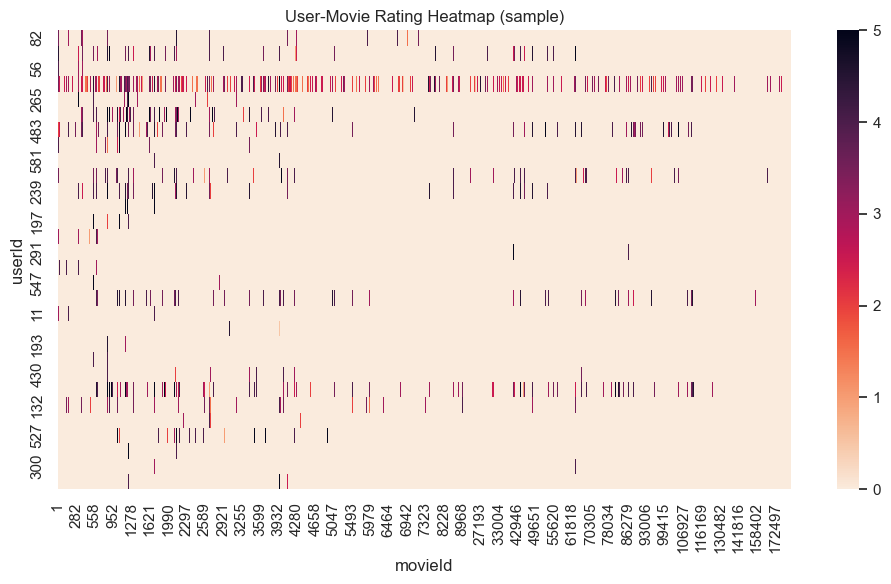

In [4]:
plot_top_genres(master_df)
plot_top_movies_by_ratings(master_df, min_count=150)
plot_rating_heatmap(master_df)

## 4. Xây dựng đặc trưng
Tạo vector TF-IDF + các thuộc tính numeric và ma trận user–item phục vụ mô hình hóa.

In [5]:
feature_store = FeatureStore()
item_df = master_df.drop_duplicates('movieId')[['movieId', 'clean_title', 'genres', 'tag_text', 'avg_rating', 'rating_count', 'rating_std', 'year']].reset_index(drop=True)
feature_matrix = feature_store.build_item_features(item_df)
ratings_df, user_item = build_user_item_matrix(master_df)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## 5. Huấn luyện mô hình
Đào tạo ba mô hình: content-based, collaborative (SVD) và hybrid.

In [6]:
content_model = ContentBasedRecommender(item_df=item_df, feature_store=feature_store, feature_matrix=feature_matrix)
collab_model = MatrixFactorizationRecommender.train(master_df[['userId', 'movieId', 'rating']])
hybrid_model = HybridRecommender(content_model=content_model, collab_model=collab_model, alpha=0.55)

## 6. Đánh giá
Tính RMSE, MAE, Precision@K và Recall@K trên tập hold-out.

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(master_df[['userId', 'movieId', 'rating']], test_size=0.2, random_state=42, stratify=master_df['userId'])
mf_model = MatrixFactorizationRecommender.train(train_df)
y_true = test_df['rating']
y_pred = [mf_model.predict_for_user(row.userId, [row.movieId])['est_rating'].iat[0] for row in test_df.itertuples()]
{
    'RMSE': rmse(y_true, y_pred),
    'MAE': mae(y_true, y_pred)
}

{'RMSE': 3.112589703618367, 'MAE': 2.8801867981959877}

In [8]:
def build_ground_truth(df):
    truth = {}
    for user, grp in df.groupby('userId'):
        truth[user] = grp.sort_values('rating', ascending=False)['movieId'].tolist()
    return truth

ground_truth = build_ground_truth(test_df)
recommendations = {}
for user in test_df['userId'].unique():
    recs = mf_model.recommend(user, item_df, top_k=10)
    recommendations[user] = recs['movieId'].tolist()

{
    'Precision@10': precision_at_k(recommendations, ground_truth, k=10),
    'Recall@10': recall_at_k(recommendations, ground_truth, k=10)
}

{'Precision@10': 0.011803278688524588, 'Recall@10': 0.002903414405390081}

## 7. Đề xuất mẫu
Kiểm tra sự khác biệt về chất lượng giữa ba thuật toán đối với một người dùng ngẫu nhiên.

In [9]:
user_id = master_df['userId'].sample(1, random_state=0).iat[0]
history = master_df[master_df['userId'] == user_id]
{
    'Content-based': content_model.recommend(history, top_k=5)[['clean_title', 'genres', 'avg_rating', 'score']],
    'Collaborative': collab_model.recommend(user_id, item_df, top_k=5)[['clean_title', 'genres', 'avg_rating', 'est_rating']],
    'Hybrid': hybrid_model.recommend(user_id, history, top_k=5)[['clean_title', 'genres', 'avg_rating', 'hybrid_score']]
}

{'Content-based':               clean_title                                   genres  \
 1028               Aliens           Action|Adventure|Horror|Sci-Fi   
 166           Matrix, The                   Action|Sci-Fi|Thriller   
 16           Pulp Fiction              Comedy|Crime|Drama|Thriller   
 69    Princess Bride, The  Action|Adventure|Comedy|Fantasy|Romance   
 1094         Blade Runner                   Action|Sci-Fi|Thriller   
 
       avg_rating       score  
 1028    3.964286  148.049115  
 166     4.192446  144.979960  
 16      4.197068  143.261429  
 69      4.232394  143.026379  
 1094    4.100806  142.730960  ,
 'Collaborative':                               clean_title                            genres  \
 32                              Rock, The         Action|Adventure|Thriller   
 49    Willy Wonka & the Chocolate Factory   Children|Comedy|Fantasy|Musical   
 278    Twelve Monkeys (a.k.a. 12 Monkeys)           Mystery|Sci-Fi|Thriller   
 1128             Star Tr

## 8. Giao diện trình diễn
Ứng dụng Streamlit (`app.py`) cung cấp giao diện đáp ứng đủ 3 tiêu chí: chọn người dùng, cấu hình thuật toán, và hiển thị bảng kết quả có kèm mô tả chi tiết.
- Chạy lệnh `streamlit run app.py` tại thư mục gốc; app tự nạp các artifact trong `models/artifacts`.
- Sidebar cho phép đổi user, lọc theo thể loại/khoảng năm, chọn mô hình (Content, Collaborative, Hybrid) và thiết lập số lượng gợi ý.
- Bảng kết quả chuẩn hóa cột `model_score`, hiển thị tiêu đề sạch, thể loại, điểm trung bình và điểm dự báo giúp so sánh nhanh giữa các phương pháp.
- Tab "Giải thích" mô tả pipeline và cách đánh giá để đáp ứng phần phân tích định tính của yêu cầu cuối.

## 9. Tổng kết & lưu vết
- Dữ liệu thô: `data/raw/ml-latest-small` (links/movies/ratings/tags).
- Dữ liệu sạch & đặc trưng: `data/processed/movies.csv`, `data/processed/ratings.csv`, `data/processed/master.parquet`, `models/artifacts/feature_store.joblib`.
- Báo cáo hình ảnh: `reports/figures/*.png` (phân bố rating, top genre, top movie, heatmap).
- Kết quả đánh giá: `reports/metrics.json` chứa RMSE/MAE/Precision@10/Recall@10.
- Ứng dụng demo: `streamlit run app.py` để trình bày trực quan và cho phép người dùng cuối tương tác.